In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE, ADASYN
from collections import Counter

pd.set_option('display.max_columns', 1000)

In [2]:
# read training data

train_data = pd.read_csv('train.csv', delimiter=';')
#train_data.head()

In [3]:
train_data, test_data = train_test_split(train_data, test_size=0.3, random_state=3)

In [4]:
print((train_data.fraud == "Y").sum())
print((test_data.fraud == "Y").sum())

207
101


In [5]:
# claim variables

train_data['claim_amount'] = train_data['claim_amount'].str.replace(',','.').astype('float64')

train_data['claim_date_registered'] = pd.to_datetime(train_data['claim_date_registered'], format='%Y%m%d')

train_data['claim_date_occured'] = pd.to_datetime(train_data['claim_date_occured'], format='%Y%m%d')

mask_night = (train_data['claim_time_occured'] >= 2200) | (train_data['claim_time_occured'] <= 700)
train_data.loc[~mask_night, 'claim_time_occured'] = 0
train_data.loc[mask_night, 'claim_time_occured'] = 1

postal_code_counts = train_data['claim_postal_code'].value_counts()
train_data = train_data.merge(postal_code_counts, how='left', left_on='claim_postal_code', right_index=True)

train_data['claim_alcohol'].fillna("MISSING", inplace=True)

train_data['claim_language'].fillna("MISSING", inplace=True)
mask = train_data['claim_language'] == 1.0
train_data.loc[mask, 'claim_language'] = "LANG A"
mask = train_data['claim_language'] == 2.0
train_data.loc[mask, 'claim_language'] = "LANG B"

train_data['claim_vehicle_id'].fillna("MISSING", inplace=True)
claim_vehicle_id_count = train_data['claim_vehicle_id'].value_counts()
claim_vehicle_id_count["MISSING"] = 0
train_data = train_data.merge(claim_vehicle_id_count, how='left', 
                              left_on='claim_vehicle_id', right_index=True)

train_data['claim_vehicle_brand'].fillna('MISSING', inplace=True)
claim_vehicle_brand_counts = train_data['claim_vehicle_brand'].value_counts()
claim_vehicle_brand_counts['MISSING'] = 0
train_data = train_data.merge(claim_vehicle_brand_counts, how='left', 
                              left_on='claim_vehicle_brand', right_index=True)


train_data['claim_vehicle_type'].fillna('MISSING', inplace=True)

train_data['claim_vehicle_date_inuse'].fillna(190001, inplace=True)
train_data['claim_vehicle_date_inuse'] = train_data['claim_vehicle_date_inuse'].astype(int)
mask = (train_data['claim_vehicle_date_inuse'] > 220000)
train_data.loc[mask, 'claim_vehicle_date_inuse'] = 190001
train_data['claim_vehicle_date_inuse'] = pd.to_datetime(train_data['claim_vehicle_date_inuse'].astype(str), 
                                                        format='%Y%m')

train_data['claim_vehicle_cyl'].fillna(10000, inplace=True)

train_data['claim_vehicle_load'].fillna(500, inplace=True)

train_data['claim_vehicle_fuel_type'].fillna('MISSING', inplace=True)
mask = train_data['claim_vehicle_fuel_type'] == 1.0
train_data.loc[mask, 'claim_vehicle_fuel_type'] = "FUEL A"
mask = train_data['claim_vehicle_fuel_type'] == 2.0
train_data.loc[mask, 'claim_vehicle_fuel_type'] = "FUEL B"

train_data['claim_vehicle_power'].fillna(1000, inplace=True)

In [6]:
# policy variables

policy_holder_id_count = train_data['policy_holder_id'].value_counts()
train_data = train_data.merge(policy_holder_id_count, how='left', 
                              left_on='policy_holder_id', right_index=True)

train_data['policy_holder_postal_code'].fillna(0, inplace=True)
policy_holder_postal_code_counts = train_data['policy_holder_postal_code'].value_counts()
policy_holder_postal_code_counts.loc[0] = 0
train_data = train_data.merge(policy_holder_postal_code_counts, how='left', 
                              left_on='policy_holder_postal_code', right_index=True)

train_data['policy_holder_year_birth'].fillna(1800, inplace=True)

train_data['policy_holder_expert_id'].fillna("MISSING", inplace=True)
policy_holder_expert_id_count = train_data['policy_holder_expert_id'].value_counts()
policy_holder_expert_id_count['MISSING'] = 0
train_data = train_data.merge(policy_holder_expert_id_count, how='left', 
                              left_on='policy_holder_expert_id', right_index=True)

In [7]:
# driver variables

driver_id_count = train_data['driver_id'].value_counts()
train_data = train_data.merge(driver_id_count, how='left', 
                              left_on='driver_id', right_index=True)

train_data['driver_postal_code'].fillna(0, inplace=True)
driver_postal_code_count = train_data['driver_postal_code'].value_counts()
driver_postal_code_count.loc[0] = 0
train_data = train_data.merge(driver_postal_code_count, how='left', 
                              left_on='driver_postal_code', right_index=True)

train_data['driver_year_birth'].fillna(1801, inplace=True)

train_data['driver_expert_id'].fillna("MISSING", inplace=True)
driver_expert_id_count = train_data['driver_expert_id'].value_counts()
driver_expert_id_count['MISSING'] = 0
train_data = train_data.merge(driver_expert_id_count, how='left', 
                              left_on='driver_expert_id', right_index=True)

train_data['driver_vehicle_id'].fillna("MISSING", inplace=True)
driver_vehicle_id_count = train_data['driver_vehicle_id'].value_counts()
driver_vehicle_id_count["MISSING"] = 0
train_data = train_data.merge(driver_vehicle_id_count, how='left', 
                              left_on='driver_vehicle_id', right_index=True)

In [8]:
# third party 1st variables

train_data['third_party_1_id'].fillna("MISSING", inplace=True)
third_party_1_id_count = train_data['third_party_1_id'].value_counts()
third_party_1_id_count["MISSING"] = 0
train_data = train_data.merge(third_party_1_id_count, how='left', 
                              left_on='third_party_1_id', right_index=True)

train_data['third_party_1_postal_code'].fillna(0, inplace=True)
third_party_1_postal_code_count = train_data['third_party_1_postal_code'].value_counts()
third_party_1_postal_code_count[0] = 0
train_data = train_data.merge(third_party_1_postal_code_count, how='left', 
                              left_on='third_party_1_postal_code', right_index=True)

train_data['third_party_1_injured'].fillna("MISSING", inplace=True)

train_data['third_party_1_vehicle_type'].fillna("MISSING", inplace=True)

train_data['third_party_1_form'].fillna("MISSING", inplace=True)

train_data['third_party_1_year_birth'].fillna(1802, inplace=True)

train_data['third_party_1_country'].fillna("MISSING", inplace=True)

train_data['third_party_1_vehicle_id'].fillna("MISSING", inplace=True)
third_party_1_vehicle_id_count = train_data['third_party_1_vehicle_id'].value_counts()
third_party_1_vehicle_id_count["MISSING"] = 0
train_data = train_data.merge(third_party_1_vehicle_id_count, how='left', 
                              left_on='third_party_1_vehicle_id', right_index=True)

train_data['third_party_1_expert_id'].fillna("MISSING", inplace=True)
third_party_1_expert_id_count = train_data['third_party_1_expert_id'].value_counts()
third_party_1_expert_id_count["MISSING"] = 0
train_data = train_data.merge(third_party_1_expert_id_count, how='left', 
                 left_on='third_party_1_expert_id', right_index=True)

In [9]:
# third party rest of variables

mask = train_data['third_party_2_id'].isna()
train_data.loc[mask, 'third_party_2_id'] = 0
train_data.loc[~mask, 'third_party_2_id'] = 1

mask = train_data['third_party_2_postal_code'].isna()
train_data.loc[mask, 'third_party_2_postal_code'] = 0
train_data.loc[~mask, 'third_party_2_postal_code'] = 1

mask = train_data['third_party_2_injured'].isna()
train_data.loc[mask, 'third_party_2_injured'] = 0
train_data.loc[~mask, 'third_party_2_injured'] = 1

mask = train_data['third_party_2_vehicle_type'].isna()
train_data.loc[mask, 'third_party_2_vehicle_type'] = 0
train_data.loc[~mask, 'third_party_2_vehicle_type'] = 1

mask = train_data['third_party_2_form'].isna()
train_data.loc[mask, 'third_party_2_form'] = 0
train_data.loc[~mask, 'third_party_2_form'] = 1

mask = train_data['third_party_2_year_birth'].isna()
train_data.loc[mask, 'third_party_2_year_birth'] = 0
train_data.loc[~mask, 'third_party_2_year_birth'] = 1

mask = train_data['third_party_2_country'].isna()
train_data.loc[mask, 'third_party_2_country'] = 0
train_data.loc[~mask, 'third_party_2_country'] = 1

mask = train_data['third_party_2_vehicle_id'].isna()
train_data.loc[mask, 'third_party_2_vehicle_id'] = 0
train_data.loc[~mask, 'third_party_2_vehicle_id'] = 1

mask = train_data['third_party_2_expert_id'].isna()
train_data.loc[mask, 'third_party_2_expert_id'] = 0
train_data.loc[~mask, 'third_party_2_expert_id'] = 1

mask = train_data['third_party_3_id'].isna()
train_data.loc[mask, 'third_party_3_id'] = 0
train_data.loc[~mask, 'third_party_3_id'] = 1

mask = train_data['third_party_3_postal_code'].isna()
train_data.loc[mask, 'third_party_3_postal_code'] = 0
train_data.loc[~mask, 'third_party_3_postal_code'] = 1

mask = train_data['third_party_3_injured'].isna()
train_data.loc[mask, 'third_party_3_injured'] = 0
train_data.loc[~mask, 'third_party_3_injured'] = 1

mask = train_data['third_party_3_vehicle_type'].isna()
train_data.loc[mask, 'third_party_3_vehicle_type'] = 0
train_data.loc[~mask, 'third_party_3_vehicle_type'] = 1

mask = train_data['third_party_3_form'].isna()
train_data.loc[mask, 'third_party_3_form'] = 0
train_data.loc[~mask, 'third_party_3_form'] = 1

mask = train_data['third_party_3_year_birth'].isna()
train_data.loc[mask, 'third_party_3_year_birth'] = 0
train_data.loc[~mask, 'third_party_3_year_birth'] = 1

mask = train_data['third_party_3_country'].isna()
train_data.loc[mask, 'third_party_3_country'] = 0
train_data.loc[~mask, 'third_party_3_country'] = 1

mask = train_data['third_party_3_vehicle_id'].isna()
train_data.loc[mask, 'third_party_3_vehicle_id'] = 0
train_data.loc[~mask, 'third_party_3_vehicle_id'] = 1

mask = train_data['third_party_3_expert_id'].isna()
train_data.loc[mask, 'third_party_3_expert_id'] = 0
train_data.loc[~mask, 'third_party_3_expert_id'] = 1

In [10]:
# repair variables

train_data['repair_id'].fillna("MISSING", inplace=True)
repair_id_count = train_data['repair_id'].value_counts()
repair_id_count["MISSING"] = 0
train_data = train_data.merge(repair_id_count, how='left', 
                 left_on='repair_id', right_index=True)

train_data['repair_postal_code'].fillna(0, inplace=True)
repair_postal_code_count = train_data['repair_postal_code'].value_counts()
repair_postal_code_count[0] = 0
train_data = train_data.merge(repair_postal_code_count, how='left', 
                 left_on='repair_postal_code', right_index=True)

train_data['repair_form'].fillna("MISSING", inplace=True)

train_data['repair_year_birth'].fillna(1804, inplace=True)

train_data['repair_country'].fillna("MISSING", inplace=True)

In [11]:
# final variables

train_data['policy_date_start'].fillna(180501, inplace=True)
train_data['policy_date_start'] = pd.to_datetime(train_data['policy_date_start'].astype(int).astype(str),
                                                 format='%Y%m')

train_data['policy_date_next_expiry'].fillna(180501, inplace=True)
train_data['policy_date_next_expiry'] = pd.to_datetime(train_data['policy_date_next_expiry'].astype(int).astype(str),
                                                       format='%Y%m')

train_data['policy_date_last_renewed'].fillna(180501, inplace=True)
train_data['policy_date_last_renewed'] = pd.to_datetime(train_data['policy_date_last_renewed'].astype(int).astype(str),
                                                        format='%Y%m')

train_data['policy_premium_100'].fillna(200, inplace=True)

train_data['policy_coverage_1000'].fillna(300, inplace=True)

train_data['policy_coverage_type'].fillna("MISSING", inplace=True)
policy_coverage_type_count = train_data['policy_coverage_type'].value_counts()
policy_coverage_type_count["MISSING"] = 0
train_data = train_data.merge(policy_coverage_type_count, how='left', 
                 left_on='policy_coverage_type', right_index=True)

In [12]:
third_cols = train_data.filter(regex='third_party_2|third_party_3').columns

In [13]:
# claim variables

#train_data['claim_amount'] = train_data['claim_amount'].str.replace(',','.').astype('float64')

test_data['claim_date_registered'] = pd.to_datetime(test_data['claim_date_registered'], format='%Y%m%d')

test_data['claim_date_occured'] = pd.to_datetime(test_data['claim_date_occured'], format='%Y%m%d')

mask_night = (test_data['claim_time_occured'] >= 2200) | (test_data['claim_time_occured'] <= 700)
test_data.loc[~mask_night, 'claim_time_occured'] = 0
test_data.loc[mask_night, 'claim_time_occured'] = 1

# postal_code_counts = train_data['claim_postal_code'].value_counts()
test_data = test_data.merge(postal_code_counts, how='left', left_on='claim_postal_code', right_index=True)

test_data['claim_alcohol'].fillna("MISSING", inplace=True)

test_data['claim_language'].fillna("MISSING", inplace=True)
mask = test_data['claim_language'] == 1.0
test_data.loc[mask, 'claim_language'] = "LANG A"
mask = test_data['claim_language'] == 2.0
test_data.loc[mask, 'claim_language'] = "LANG B"

test_data['claim_vehicle_id'].fillna("MISSING", inplace=True)
#claim_vehicle_id_count = train_data['claim_vehicle_id'].value_counts()
#claim_vehicle_id_count["MISSING"] = 0
test_data = test_data.merge(claim_vehicle_id_count, how='left', 
                              left_on='claim_vehicle_id', right_index=True)

test_data['claim_vehicle_brand'].fillna('MISSING', inplace=True)
#claim_vehicle_brand_counts = train_data['claim_vehicle_brand'].value_counts()
#claim_vehicle_brand_counts['MISSING'] = 0
test_data = test_data.merge(claim_vehicle_brand_counts, how='left', 
                              left_on='claim_vehicle_brand', right_index=True)

test_data['claim_vehicle_date_inuse'].fillna(190001.0, inplace=True)
mask = (test_data['claim_vehicle_date_inuse'] > 210001.0)
test_data.loc[mask, 'claim_vehicle_date_inuse'] = 190001.0
test_data['claim_vehicle_date_inuse'] = pd.to_datetime(test_data['claim_vehicle_date_inuse'].astype(int).astype(str), 
                                                        format='%Y%m')

test_data['claim_vehicle_cyl'].fillna(10000, inplace=True)

test_data['claim_vehicle_load'].fillna(500, inplace=True)

test_data['claim_vehicle_fuel_type'].fillna('MISSING', inplace=True)
mask = test_data['claim_vehicle_fuel_type'] == 1.0
test_data.loc[mask, 'claim_vehicle_fuel_type'] = "FUEL A"
mask = test_data['claim_vehicle_fuel_type'] == 2.0
test_data.loc[mask, 'claim_vehicle_fuel_type'] = "FUEL B"

test_data['claim_vehicle_type'].fillna('MISSING', inplace=True)

test_data['claim_vehicle_power'].fillna(1000, inplace=True)

In [14]:
# policy variables

#policy_holder_id_count = train_data['policy_holder_id'].value_counts()
test_data = test_data.merge(policy_holder_id_count, how='left', 
                              left_on='policy_holder_id', right_index=True)

test_data['policy_holder_postal_code'].fillna(0, inplace=True)
#policy_holder_postal_code_counts = train_data['policy_holder_postal_code'].value_counts()
#policy_holder_postal_code_counts.loc[0] = 0
test_data = test_data.merge(policy_holder_postal_code_counts, how='left', 
                              left_on='policy_holder_postal_code', right_index=True)

test_data['policy_holder_year_birth'].fillna(1800, inplace=True)

test_data['policy_holder_expert_id'].fillna("MISSING", inplace=True)
#policy_holder_expert_id_count = train_data['policy_holder_expert_id'].value_counts()
#policy_holder_expert_id_count['MISSING'] = 0
test_data = test_data.merge(policy_holder_expert_id_count, how='left', 
                              left_on='policy_holder_expert_id', right_index=True)

In [15]:
# driver variables

#driver_id_count = train_data['driver_id'].value_counts()
test_data = test_data.merge(driver_id_count, how='left', 
                              left_on='driver_id', right_index=True)

test_data['driver_postal_code'].fillna(0, inplace=True)
#driver_postal_code_count = train_data['driver_postal_code'].value_counts()
#driver_postal_code_count.loc[0] = 0
test_data = test_data.merge(driver_postal_code_count, how='left', 
                              left_on='driver_postal_code', right_index=True)

test_data['driver_year_birth'].fillna(1801, inplace=True)

test_data['driver_expert_id'].fillna("MISSING", inplace=True)
#driver_expert_id_count = train_data['driver_expert_id'].value_counts()
#driver_expert_id_count['MISSING'] = 0
test_data = test_data.merge(driver_expert_id_count, how='left', 
                              left_on='driver_expert_id', right_index=True)

test_data['driver_vehicle_id'].fillna("MISSING", inplace=True)
#driver_vehicle_id_count = train_data['driver_vehicle_id'].value_counts()
#driver_vehicle_id_count["MISSING"] = 0
test_data = test_data.merge(driver_vehicle_id_count, how='left', 
                              left_on='driver_vehicle_id', right_index=True)

In [16]:
# third party 1st variables

test_data['third_party_1_id'].fillna("MISSING", inplace=True)
#third_party_1_id_count = train_data['third_party_1_id'].value_counts()
#third_party_1_id_count["MISSING"] = 0
test_data = test_data.merge(third_party_1_id_count, how='left', 
                              left_on='third_party_1_id', right_index=True)

test_data['third_party_1_postal_code'].fillna(0, inplace=True)
#third_party_1_postal_code_count = train_data['third_party_1_postal_code'].value_counts()
#third_party_1_postal_code_count[0] = 0
test_data = test_data.merge(third_party_1_postal_code_count, how='left', 
                              left_on='third_party_1_postal_code', right_index=True)

test_data['third_party_1_injured'].fillna("MISSING", inplace=True)

test_data['third_party_1_vehicle_type'].fillna("MISSING", inplace=True)

test_data['third_party_1_form'].fillna("MISSING", inplace=True)

test_data['third_party_1_year_birth'].fillna(1802, inplace=True)

test_data['third_party_1_country'].fillna("MISSING", inplace=True)

test_data['third_party_1_vehicle_id'].fillna("MISSING", inplace=True)
#third_party_1_vehicle_id_count = train_data['third_party_1_vehicle_id'].value_counts()
#third_party_1_vehicle_id_count["MISSING"] = 0
test_data = test_data.merge(third_party_1_vehicle_id_count, how='left', 
                              left_on='third_party_1_vehicle_id', right_index=True)

test_data['third_party_1_expert_id'].fillna("MISSING", inplace=True)
#third_party_1_expert_id_count = train_data['third_party_1_expert_id'].value_counts()
#third_party_1_expert_id_count["MISSING"] = 0
test_data = test_data.merge(third_party_1_expert_id_count, how='left', 
                 left_on='third_party_1_expert_id', right_index=True)

In [17]:
# third party rest of variables

mask = test_data['third_party_2_id'].isna()
test_data.loc[mask, 'third_party_2_id'] = 0
test_data.loc[~mask, 'third_party_2_id'] = 1

mask = test_data['third_party_2_postal_code'].isna()
test_data.loc[mask, 'third_party_2_postal_code'] = 0
test_data.loc[~mask, 'third_party_2_postal_code'] = 1

mask = test_data['third_party_2_injured'].isna()
test_data.loc[mask, 'third_party_2_injured'] = 0
test_data.loc[~mask, 'third_party_2_injured'] = 1

mask = test_data['third_party_2_vehicle_type'].isna()
test_data.loc[mask, 'third_party_2_vehicle_type'] = 0
test_data.loc[~mask, 'third_party_2_vehicle_type'] = 1

mask = test_data['third_party_2_form'].isna()
test_data.loc[mask, 'third_party_2_form'] = 0
test_data.loc[~mask, 'third_party_2_form'] = 1

mask = test_data['third_party_2_year_birth'].isna()
test_data.loc[mask, 'third_party_2_year_birth'] = 0
test_data.loc[~mask, 'third_party_2_year_birth'] = 1

mask = test_data['third_party_2_country'].isna()
test_data.loc[mask, 'third_party_2_country'] = 0
test_data.loc[~mask, 'third_party_2_country'] = 1

mask = test_data['third_party_2_vehicle_id'].isna()
test_data.loc[mask, 'third_party_2_vehicle_id'] = 0
test_data.loc[~mask, 'third_party_2_vehicle_id'] = 1

mask = test_data['third_party_2_expert_id'].isna()
test_data.loc[mask, 'third_party_2_expert_id'] = 0
test_data.loc[~mask, 'third_party_2_expert_id'] = 1

mask = test_data['third_party_3_id'].isna()
test_data.loc[mask, 'third_party_3_id'] = 0
test_data.loc[~mask, 'third_party_3_id'] = 1

mask = test_data['third_party_3_postal_code'].isna()
test_data.loc[mask, 'third_party_3_postal_code'] = 0
test_data.loc[~mask, 'third_party_3_postal_code'] = 1

mask = test_data['third_party_3_injured'].isna()
test_data.loc[mask, 'third_party_3_injured'] = 0
test_data.loc[~mask, 'third_party_3_injured'] = 1

mask = test_data['third_party_3_vehicle_type'].isna()
test_data.loc[mask, 'third_party_3_vehicle_type'] = 0
test_data.loc[~mask, 'third_party_3_vehicle_type'] = 1

mask = test_data['third_party_3_form'].isna()
test_data.loc[mask, 'third_party_3_form'] = 0
test_data.loc[~mask, 'third_party_3_form'] = 1

mask = test_data['third_party_3_year_birth'].isna()
test_data.loc[mask, 'third_party_3_year_birth'] = 0
test_data.loc[~mask, 'third_party_3_year_birth'] = 1

mask = test_data['third_party_3_country'].isna()
test_data.loc[mask, 'third_party_3_country'] = 0
test_data.loc[~mask, 'third_party_3_country'] = 1

mask = test_data['third_party_3_vehicle_id'].isna()
test_data.loc[mask, 'third_party_3_vehicle_id'] = 0
test_data.loc[~mask, 'third_party_3_vehicle_id'] = 1

mask = test_data['third_party_3_expert_id'].isna()
test_data.loc[mask, 'third_party_3_expert_id'] = 0
test_data.loc[~mask, 'third_party_3_expert_id'] = 1

In [18]:
# repair variables

test_data['repair_id'].fillna("MISSING", inplace=True)
#repair_id_count = train_data['repair_id'].value_counts()
#repair_id_count["MISSING"] = 0
test_data = test_data.merge(repair_id_count, how='left', 
                 left_on='repair_id', right_index=True)

test_data['repair_postal_code'].fillna(0, inplace=True)
#repair_postal_code_count = train_data['repair_postal_code'].value_counts()
#repair_postal_code_count[0] = 0
test_data = test_data.merge(repair_postal_code_count, how='left', 
                 left_on='repair_postal_code', right_index=True)

test_data['repair_form'].fillna("MISSING", inplace=True)

test_data['repair_year_birth'].fillna(1804, inplace=True)

test_data['repair_country'].fillna("MISSING", inplace=True)

In [19]:
# final variables

test_data['policy_date_start'].fillna(180501, inplace=True)
test_data['policy_date_start'] = pd.to_datetime(test_data['policy_date_start'].astype(int).astype(str),
                                                 format='%Y%m')

test_data['policy_date_next_expiry'].fillna(180501, inplace=True)
test_data['policy_date_next_expiry'] = pd.to_datetime(test_data['policy_date_next_expiry'].astype(int).astype(str),
                                                       format='%Y%m')

test_data['policy_date_last_renewed'].fillna(180501, inplace=True)
test_data['policy_date_last_renewed'] = pd.to_datetime(test_data['policy_date_last_renewed'].astype(int).astype(str),
                                                        format='%Y%m')

test_data['policy_premium_100'].fillna(200, inplace=True)

test_data['policy_coverage_1000'].fillna(300, inplace=True)

test_data['policy_coverage_type'].fillna("MISSING", inplace=True)
#policy_coverage_type_count = train_data['policy_coverage_type'].value_counts()
#policy_coverage_type_count["MISSING"] = 0
test_data = test_data.merge(policy_coverage_type_count, how='left', 
                 left_on='policy_coverage_type', right_index=True)

In [20]:
test_data.fillna(0, inplace=True)

In [21]:
# drop cols for now
dropcols = ['claim_id', 'claim_postal_code_x', 'claim_vehicle_id_x', 'claim_vehicle_brand_x',
       'policy_holder_id_x', 'policy_holder_postal_code_x',
       'policy_holder_expert_id_x', 'driver_id_x', 'driver_postal_code_x',
       'driver_expert_id_x', 'driver_vehicle_id_x', 'third_party_1_id_x',
       'third_party_1_postal_code_x', 'third_party_1_vehicle_id_x',
       'third_party_1_expert_id_x', 'repair_id_x', 'repair_postal_code_x',
       'claim_date_registered', 'claim_date_occured', 'claim_vehicle_date_inuse',
       'policy_date_start', 'policy_date_next_expiry', 'policy_date_last_renewed', 'policy_coverage_type_x']

clean_data = train_data.drop(columns=dropcols)

# encode predictors
test_data['claim_amount'] = test_data['claim_amount'].str.replace(',','.').astype('float64')
X_test = test_data.drop(columns=dropcols).drop(columns=['fraud', 'claim_amount'])
encoded_predictors = pd.get_dummies(X_test)

### Lets take a look on the cleaned train_data

<AxesSubplot:>

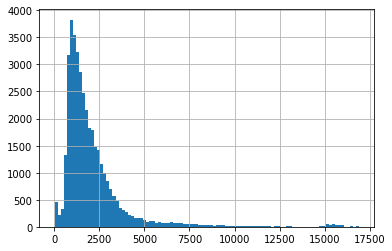

In [22]:
clean_data['claim_amount'].hist(bins=100)

In [23]:
clean_data.sort_values(by='claim_amount', ascending=False)

,fraud,claim_amount,claim_time_occured,claim_cause,claim_liable,claim_num_injured,claim_num_third_parties,claim_num_vehicles,claim_police,claim_alcohol,claim_language,claim_vehicle_type,claim_vehicle_cyl,claim_vehicle_load,claim_vehicle_fuel_type,claim_vehicle_power,policy_holder_form,policy_holder_year_birth,policy_holder_country,driver_form,driver_year_birth,driver_country,driver_injured,third_party_1_injured,third_party_1_vehicle_type,third_party_1_form,third_party_1_year_birth,third_party_1_country,third_party_2_id,third_party_2_postal_code,third_party_2_injured,third_party_2_vehicle_type,third_party_2_form,third_party_2_year_birth,third_party_2_country,third_party_2_vehicle_id,third_party_2_expert_id,third_party_3_id,third_party_3_postal_code,third_party_3_injured,third_party_3_vehicle_type,third_party_3_form,third_party_3_year_birth,third_party_3_country,third_party_3_vehicle_id,third_party_3_expert_id,repair_form,repair_year_birth,repair_country,repair_sla,policy_num_changes,policy_num_claims,policy_premium_100,policy_coverage_1000,claim_postal_code_y,claim_vehicle_id_y,claim_vehicle_brand_y,policy_holder_id_y,policy_holder_postal_code_y,policy_holder_expert_id_y,driver_id_y,driver_postal_code_y,driver_expert_id_y,driver_vehicle_id_y,third_party_1_id_y,third_party_1_postal_code_y,third_party_1_vehicle_id_y,third_party_1_expert_id_y,repair_id_y,repair_postal_code_y,policy_coverage_type_y
443,Y,16901.0,0.0,fire,N,0,0,3,Y,MISSING,LANG A,car,1240.0,1.49,FUEL A,59.0,F,1947.0,B,F,1947.0,B,N,MISSING,MISSING,MISSING,1802.0,MISSING,0,0.0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0.0,0,0,0.0,MISSING,1804.0,MISSING,N,3,1,10.0,10.0,93,1,953,1,118,13,1,151,19,1,0,0,0,0,0,0,703
20169,Y,16895.0,0.0,theft,N,0,0,3,Y,MISSING,LANG A,car,1560.0,1.56,FUEL B,68.0,F,1989.0,B,M,1944.0,B,N,MISSING,MISSING,MISSING,1802.0,MISSING,0,0.0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0.0,0,0,0.0,C,1804.0,B,N,0,3,9.0,18.0,58,1,2709,4,63,0,6,61,26,1,0,0,0,0,11,24,5624
11682,Y,16859.0,0.0,traffic accident,Y,1,4,2,Y,N,LANG B,van,1560.0,1.96,FUEL B,55.0,M,1973.0,B,M,1973.0,B,N,N,MISSING,M,1968.0,B,1,1.0,1,0,1,1.0,1,0,0,0,0.0,0,0,0,0.0,0,0,0.0,MISSING,1804.0,MISSING,N,0,1,3.0,300.0,92,1,2709,6,222,0,4,233,0,1,1,18,0,7,0,0,8130
6689,Y,16798.0,0.0,theft,N,0,0,2,Y,MISSING,LANG B,MISSING,0.0,500.00,MISSING,0.0,M,1938.0,B,M,1938.0,B,N,MISSING,MISSING,MISSING,1802.0,MISSING,0,0.0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0.0,0,0,0.0,MISSING,1804.0,MISSING,N,3,0,4.0,18.0,1,0,0,1,98,47,1,97,66,0,0,0,0,0,0,0,47
47379,Y,16793.0,0.0,other,N,0,0,4,N,MISSING,LANG A,car,998.0,1.55,FUEL A,74.0,M,1988.0,B,F,1991.0,B,N,MISSING,MISSING,MISSING,1802.0,MISSING,0,0.0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0.0,0,0,0.0,MISSING,1804.0,MISSING,N,5,1,17.0,20.0,55,1,2628,1,52,0,4,51,17,1,0,0,0,0,0,0,2262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43620,N,35.0,0.0,traffic accident,N,0,1,2,N,MISSING,LANG B,car,1398.0,1.62,FUEL B,50.0,F,1956.0,B,F,1956.0,B,N,N,bus,C,1802.0,B,0,0.0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0.0,0,0,0.0,MISSING,1804.0,MISSING,N,0,5,4.0,12.0,67,1,2712,8,92,0,6,89,0,1,6,52,1,0,0,0,861
53814,N,35.0,0.0,traffic accident,Y,0,1,3,N,MISSING,LANG B,car,2987.0,500.00,FUEL B,1000.0,M,1800.0,B,M,1801.0,B,N,N,car,C,1802.0,B,0,0.0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0.0,0,0,0.0,C,1804.0,B,N,0,1,200.0,300.0,30,0,0,1,194,416,1,184,565,0,1,201,1,0,2,45,6468
48470,N,34.0,0.0,traffic accident,Y,0,1,3,N,MISSING,LANG B,car,0.0,500.00,FUEL B,74.0,F,1800.0,B,M,1971.0,B,N,N,car,M,1802.0,B,0,0.0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0.0,0,0,0.0,MISSING,1804.0,MISSING,N,0,1,4.0,300.0,28,1,0,1,40,0,9,39,0,1,1,32,1,0,0,0,8130
11917,N,30.0,0.0,traffic accident,N,0,1,3,N,MISSING,LANG A,van,2299.0,3.30,FUEL B,92.0,M,1957.0,B,M,1957.0,B,N,N,car,C,1802.0,B,0,0.0,0,0,0,0.0,0,0,0,0,0.0,0,0,0,0.0,0,0,0.0,C,1804.0,B,Y,0,4,7.0,19.0,13,1,

In [24]:
# let's try pure vanilla

# find all positives with less than 1000E claim amount
indices = clean_data[(clean_data['fraud'] == 'Y') & (clean_data['claim_amount'] < 1000)].index
print(indices)

Int64Index([26123, 53773, 39473, 15317, 26111, 18195, 47353, 52437, 25851,
            45154, 41973, 50936, 30832,  4866, 38660, 30401,  8929, 43615,
            11014, 16787, 48216, 32432,  6220],
           dtype='int64')


In [25]:
# more than 3000 claim amount
high_value_targets_indices = clean_data[(clean_data['fraud'] == 'Y') & (clean_data['claim_amount'] > 3000)].index
print(high_value_targets_indices)

Int64Index([17946, 34317,  9160, 54293, 27927, 52640, 35515, 43161, 38152,
            52228,
            ...
            28794, 31525, 12498, 32899,  3208, 23578,  8543, 13857, 18731,
            47611],
           dtype='int64', length=111)


In [26]:
# target and covariates
# drop tiny amount positives
y_train = clean_data.drop(indices)['fraud']
X_train = clean_data.drop(indices).drop(columns=['fraud', 'claim_amount'])

In [27]:
concat_data = pd.concat((y_train, X_train))

In [28]:
concat_data

,0,claim_alcohol,claim_cause,claim_language,claim_liable,claim_num_injured,claim_num_third_parties,claim_num_vehicles,claim_police,claim_postal_code_y,claim_time_occured,claim_vehicle_brand_y,claim_vehicle_cyl,claim_vehicle_fuel_type,claim_vehicle_id_y,claim_vehicle_load,claim_vehicle_power,claim_vehicle_type,driver_country,driver_expert_id_y,driver_form,driver_id_y,driver_injured,driver_postal_code_y,driver_vehicle_id_y,driver_year_birth,policy_coverage_1000,policy_coverage_type_y,policy_holder_country,policy_holder_expert_id_y,policy_holder_form,policy_holder_id_y,policy_holder_postal_code_y,policy_holder_year_birth,policy_num_changes,policy_num_claims,policy_premium_100,repair_country,repair_form,repair_id_y,repair_postal_code_y,repair_sla,repair_year_birth,third_party_1_country,third_party_1_expert_id_y,third_party_1_form,third_party_1_id_y,third_party_1_injured,third_party_1_postal_code_y,third_party_1_vehicle_id_y,third_party_1_vehicle_type,third_party_1_year_birth,third_party_2_country,third_party_2_expert_id,third_party_2_form,third_party_2_id,third_party_2_injured,third_party_2_postal_code,third_party_2_vehicle_id,third_party_2_vehicle_type,third_party_2_year_birth,third_party_3_country,third_party_3_expert_id,third_party_3_form,third_party_3_id,third_party_3_injured,third_party_3_postal_code,third_party_3_vehicle_id,third_party_3_vehicle_type,third_party_3_year_birth
649,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
44640,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37519,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53191,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9817,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25544,NaN,MISSING,traffic accident,LANG B,Y,0.0,1.0,3.0,N,51.0,0.0,0.0,10000.0,FUEL B,0.0,500.00,1000.0,car,B,0.0,M,74.0,N,233.0,0.0,1801.0,300.0,6468.0,B,0.0,M,1.0,214.0,1974.0,0.0,1.0,200.0,MISSING,MISSING,0.0,0.0,N,1804.0,B,0.0,F,2.0,N,64.0,1.0,car,1945.0,0,0,0,0,0,0.0,0,0,0.0,0,0.0,0,0,0,0.0,0,0,0.0
48056,NaN,MISSING,traffic accident,LANG B,N,0.0,1.0,3.0,N,60.0,0.0,3488.0,1390.0,FUEL A,1.0,1.67,55.0,car,B,0.0,M,7.0,N,10.0,1.0,1979.0,300.0,8130.0,B,0.0,F,5.0,12.0,1982.0,0.0,0.0,3.0,B,C,9.0,26.0,Y,1804.0,B,0.0,M,10.0,N,86.0,1.0,car,1802.0,0,0,0,0,0,0.0,0,0,0.0,0,0.0,0,0,0,0.0,0,0,0.0
11513,NaN,MISSING,traffic accident,LANG A,Y,0.0,1.0,4.0,N,155.0,0.0,0.0,10000.0,FUEL B,0.0,500.00,1000.0,car,B,0.0,M,1.0,N,254.0,0.0,1801.0,300.0,6468.0,B,0.0,M,6.0,145.0,1945.0,0.0,0.0,200.0,MISSING,MISSING,0.0,0.0,N,1804.0,B,0.0,C,1.0,N,183.0,1.0,car,1802.0,0,0,0,0,0,0.0,0,0,0.0,0,0.0,0,0,0,0.0,0,0,0.0


In [29]:
pd.plotting.scatter_matrix(concat_data.iloc[:,[0] + list(range(10,30))], figsize=(12,12));

Error in callback <function flush_figures at 0x0000020115475DC0> (for post_execute):


KeyboardInterrupt: 

In [31]:
# cast correct dtype - this is just needed, no smart thing happening
X_train[third_cols] = X_train[third_cols].apply(pd.to_numeric)

In [32]:
# encode covars
encoded_covariates = pd.get_dummies(X_train)
encoded_target = pd.get_dummies(y_train)['Y']

In [33]:
######################
### run model ver ####
######################

# run model
rf = RandomForestClassifier(n_estimators = 200)

# predict
rf.fit(encoded_covariates, encoded_target)

predictions = rf.predict_proba(encoded_predictors)
pred_df = pd.DataFrame(predictions)
pred_df['claim_id'] = test_data['claim_id'].values
pred_df.drop(columns=0, inplace=True)
pred_df.sort_values(by=1, ascending=False, inplace=True)

# find true positives
mask = (test_data['fraud'] == 'Y')
#keep amount and ID
frauds = test_data.loc[mask, ['claim_id', 'claim_amount']]
# merge true positives with predictions and get top 100 predictions, if they are correct, and what we got out
score = frauds.merge(pred_df.iloc[:100,:], how='right', on='claim_id')['claim_amount'].sum() / frauds.merge(pred_df, how='right', on='claim_id')['claim_amount'].sum()
score

0.5576477212705276

In [34]:
frauds['claim_amount'].sum() # 704079.74

600234.48

Train
- 638017.16
- 704079.74
- 573223.0

In [35]:
frauds['claim_amount'].sort_values(ascending=False).head(100).sum()

600077.4899999999

In [36]:
frauds.merge(pred_df.iloc[:100,:], how='right', on='claim_id')['claim_amount'].sum() 

334719.39

In [37]:
predicted_test = rf.predict(encoded_predictors)
predicted_test

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [38]:
labels_test = test_data.loc[:,['claim_id', 'fraud', 'claim_amount']]
labels_test.head()

,claim_id,fraud,claim_amount
52873,62879,N,3395.00
12916,22918,N,930.01
24942,34944,N,2665.92
19928,29930,N,821.57
34744,44749,N,1256.17


In [39]:
labels_test.loc[labels_test['fraud']=='Y', 'fraud'] = 1
labels_test.loc[labels_test['fraud']=='N', 'fraud'] = 0

In [40]:
labels_test.head()
labels_test.to_numpy()

array([[62879, 0, 3395.0],
       [22918, 0, 930.01],
       [34944, 0, 2665.92],
       ...,
       [20403, 0, 2047.38],
       [33059, 0, 953.17],
       [28747, 0, 3521.0]], dtype=object)

In [41]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01)

In [42]:
gbc.fit(encoded_covariates, encoded_target)

GradientBoostingClassifier(learning_rate=0.01)

In [43]:
from sklearn.model_selection import GridSearchCV

In [44]:
# upper lvl hyper-parameter tuning
param_test1 = {'n_estimators':range(20,81,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), 
param_grid = param_test1, scoring='roc_auc',n_jobs=4, cv=5)


In [45]:
gsearch1.fit(encoded_covariates, encoded_target)

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=8,
                                                  max_features='sqrt',
                                                  min_samples_leaf=50,
                                                  min_samples_split=500,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4, param_grid={'n_estimators': range(20, 81, 10)},
             scoring='roc_auc')

In [46]:
gsearch1.best_params_, gsearch1.best_score_

({'n_estimators': 40}, 0.894825699958908)

In [47]:
predictions = gsearch1.predict_proba(encoded_predictors)
pred_df = pd.DataFrame(predictions)
pred_df['claim_id'] = test_data['claim_id'].values
pred_df.drop(columns=0, inplace=True)
pred_df.sort_values(by=1, ascending=False, inplace=True)

# find true positives
mask = (test_data['fraud'] == 'Y')
#keep amount and ID
frauds = test_data.loc[mask, ['claim_id', 'claim_amount']]
# merge true positives with predictions and get top 100 predictions, if they are correct, and what we got out
score = frauds.merge(pred_df.iloc[:100,:], how='right', on='claim_id')['claim_amount'].sum() / frauds.merge(pred_df, how='right', on='claim_id')['claim_amount'].sum()
score

0.42711101834736315

In [218]:
##

In [207]:
predictions = gbc.predict_proba(encoded_predictors)
pred_df = pd.DataFrame(predictions)
pred_df['claim_id'] = test_data['claim_id'].values
pred_df.drop(columns=0, inplace=True)
pred_df.sort_values(by=1, ascending=False, inplace=True)

# find true positives
mask = (test_data['fraud'] == 'Y')
#keep amount and ID
frauds = test_data.loc[mask, ['claim_id', 'claim_amount']]
# merge true positives with predictions and get top 100 predictions, if they are correct, and what we got out
score = frauds.merge(pred_df.iloc[:100,:], how='right', on='claim_id')['claim_amount'].sum() / frauds.merge(pred_df, how='right', on='claim_id')['claim_amount'].sum()
score

0.45893728064405764

In [219]:
param_test3 = {'min_samples_split':range(1000,2100,200), 'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingClassifier(learning_rate=0.1, n_estimators=60,max_depth=9,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[predictors],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=8,
                                                  max_features='sqrt',
                                                  min_samples_leaf=50,
                                                  min_samples_split=500,
                                                  random_state=10,
                                                  subsample=0.8),
             n_jobs=4, param_grid={'n_estimators': range(20, 81, 10)},
             scoring='roc_auc')